In [1]:
import numpy as np
import os
from cellpose import utils, io, models
from cellpose import plot
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import quad
from skimage.io import imread
import imgaug.augmenters as iaa
import cv2
import json

In [2]:
def ctc_2_CNet(path_X,path_Y,suff_X,suff_Y,start_ind,mu,shape,half=True,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/',test=False):
    
    
    if test:
        save_dir=save_dir.replace('train', 'test')
    
    if not os.path.exists(save_dir + '/target/'):
        os.makedirs(save_dir + '/target/')
        
    if not os.path.exists(save_dir + '/source/'):
        os.makedirs(save_dir + '/source/')
    
    
    data=[]
    l_ind=start_ind
    for i in range(3500):
        
        try:
            path_r_X=path_X+'/'+suff_X+'{:03d}'.format(i)+'.tif'
            path_r_Y=path_Y+'/TRA/'+suff_Y+'{:03d}'.format(i)+'.tif'
            # read the tif file
            #print('p',path_r)
            #try:
            #img_r_X = tiff.imread(path_r_X)
            #img_r_Y = tiff.imread(path_r_Y)
            img_r_X = imread(path_r_X)
            img_r_Y = imread(path_r_Y)


            max_X=np.max(img_r_X)
            img_r_X = (img_r_X/max_X)*255
            max_y=np.max(img_r_Y)
            img_r_Y = (img_r_Y/max_y)*255


            if half:
                #print('shape',shape)
                start_x = np.random.randint(0, int(shape[1]/2))
                end_x = start_x + int(shape[1]/2)
                start_y = np.random.randint(0, int(shape[0]/2))
                end_y = start_y + int(shape[0]/2)
                #print(start_y,end_y, start_x,end_x)
                # Crop the random region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]

            #print('both shapes',img_r_X.shape,img_r_Y.shape)
            img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


            #if alt==1:
            #    cv2.imwrite(output_path_Y_c, img_r_Y)


            img_r_Y = source2CNet(img_r_Y, mu,test=test)

            #print('source worked')

            # Specify the output file path





            output_path_X = save_dir+'/target/'+str(start_ind+i)+'.png'
            output_path_Y = save_dir+'/source/'+str(start_ind+i)+'.png'
            #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'



            # Save the resized image as PNG
            cv2.imwrite(output_path_X, img_r_X)
            cv2.imwrite(output_path_Y, img_r_Y)


            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            l_ind=l_ind+1

                # Write the data list as JSON to a file


        
        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                traceback.print_exc()
            #print("An error occurred:", str(e))
        
        
        
    output_path = save_dir + "/prompt.json"

    # Check if file exists, if not create it
    if not os.path.exists(output_path):
        open(output_path, 'a').close()   
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind





def mean_ind(indices):
    """Get the mean indices from a list of indices."""
    return np.mean(indices, axis=0)

def source2CNet(img, mu,test=False):
    # Find unique values and their counts, ignoring zeros
    unique_values, unique_counts = np.unique(img, return_counts=True)
    non_zero_mask = unique_values != 0
    unique_values = unique_values[non_zero_mask]
    unique_counts = unique_counts[non_zero_mask]

    # Lists to store the mean position of each unique value and their respective counts
    pos_list = []
    count_list = []

    for value in unique_values:
        mask = img == value
        indices = np.argwhere(mask)
        m_ind = mean_ind(indices)
        pos_list.append(m_ind)

    # Initialize an output image of zeros
    image_tensor = np.zeros_like(img, dtype=np.uint8)
    
    if test:
        pos_list = generate_similar_positions2(pos_list)
    
    # Determine the radius for the painted dots
    radius = int(np.sqrt(mu / np.pi)/4)
    
    # Iterate over the mean positions and draw the dots
    for position in pos_list:
        x, y = int(position[0]), int(position[1])
        
        # Draw a dot on the image_tensor around this position
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                if (i**2 + j**2 <= radius**2):
                    try:
                        image_tensor[x+i, y+j] = 255
                    except IndexError:
                        pass

    return image_tensor


def generate_similar_positions2(positions):
    # Calculate pairwise distances
    positions = np.array(positions)
    pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)

    # Get the minimum distance from the pairwise_distances
    min_distance = np.min(pairwise_distances + np.eye(pairwise_distances.shape[0]) * np.max(pairwise_distances))

    # Create an empty list for new positions
    new_positions = []

    # Initial random position
    new_positions.append(np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0)))

    # Maximal number of attempts to generate a point that keeps minimal distance
    max_attempts = 1000
    attempts = 0

    while len(new_positions) < len(positions):
        if attempts > max_attempts:
            print("Cannot generate desired number of positions with the current minimal distance.")
            break

        # Sample random point
        random_point = np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0))

        # Construct KDTree
        tree = KDTree(new_positions)

        # Get the distances and indices of the closest points to the random_point
        distances, indices = tree.query(random_point, k=1)

        # Check if the minimum distance condition holds
        if distances >= min_distance:
            new_positions.append(random_point.tolist())
        else:
            attempts += 1

    # Convert list to numpy array
    new_positions = np.array(new_positions)

    return new_positions

def list_target_directories(path):
    # A set of names we are looking for
    target_names = {f"{i:02}" for i in range(1, 100)} # assuming 01 to 99 as the possible names

    # List to store the directories found
    found_dirs = []

    # Walk through the root directory
    for dirpath, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            if dirname in target_names:
                found_dirs.append(os.path.join(dirpath, dirname))
    
    return found_dirs

def cellpose_segmentation(path):
    model = models.Cellpose(gpu=False, model_type='cyto2')
    chan = [0,0]
    directories=list_target_directories(path)
    print(directories)
    #print(stop)
    for directory in directories:
        # Get a list of all tif files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.TIF')]

        for f in files:
            # Create output filename
            output_filename = f.replace('.tif', '_cp_masks.png').replace('.TIF', '_cp_masks.png')
            output_filepath = os.path.join(directory+'_CP', output_filename)
            print('out',output_filepath)
            # Check if the output file already exists. If it does, skip computation and saving
            if os.path.exists(output_filepath):
                print(f"{output_filename} already exists. Skipping...")
                continue

            print(f)
            img = io.imread(directory+'/'+f)
            masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)

            # save results so you can load in gui
            io.masks_flows_to_seg(img, masks, flows, diams, f, chan)
            unique_values, unique_counts = np.unique(masks, return_counts=True)
            print(masks,masks.shape,unique_values,len(unique_values)-1)

            # save results as png
            io.save_to_png(img, masks, flows, directory+'_CP/'+f)
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
            plt.tight_layout()
            plt.show()
    
def generate_CTC_datasets(path,name,save_dir):
    cellpose_segmentation(path)
    mu,sig,n,b,b_max,shape=process_images(path)
    #print('shape_before!!!',shape)
    generate_XY_pairs(path,mu,sig,shape,name, save_dir)
    

def process_images(root_path):
    all_pixel_counts = []
    all_displacements = []

    # For area calculation
    for dirpath, dirnames, filenames in os.walk(root_path):
        if os.path.basename(dirpath).endswith('_CP') and os.path.basename(dirpath)[:2].isdigit():
            for file in filenames:
                if file.endswith('.png'):
                    img_path = os.path.join(dirpath, file)
                    img = np.array(Image.open(img_path))
                    unique_values, counts = np.unique(img, return_counts=True)
                    all_pixel_counts.extend(counts[unique_values != 0])

    first_image_shape = None
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        if (os.path.basename(dirpath) == 'TRA' and 
            os.path.dirname(dirpath).endswith('_GT') and 
            os.path.basename(os.path.dirname(dirpath))[:2].isdigit()):

            filenames = sorted([f for f in filenames if f.startswith('man_track') and f.endswith('.tif')])
            print('filenames',filenames)
            for idx in range(len(filenames) - 1):
                img1_path = os.path.join(dirpath, filenames[idx])
                img2_path = os.path.join(dirpath, filenames[idx + 1])

                img1 = np.array(Image.open(img1_path))
                img2 = np.array(Image.open(img2_path))

                # Check image shapes
                if first_image_shape is None:
                    first_image_shape = img1.shape
                assert img1.shape == first_image_shape, f"Image {img1_path} has a different shape {img1.shape} than the first image shape {first_image_shape}"
                assert img2.shape == first_image_shape, f"Image {img2_path} has a different shape {img2.shape} than the first image shape {first_image_shape}"

                displacements = calculate_displacement(img1, img2)
                all_displacements.extend(displacements)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram for pixel counts
    hist_vals, bin_edges = np.histogram(all_pixel_counts, bins=75)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)))
    A, mu, sigma = popt
    ax[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    ax[0].plot(bin_centers, one_gaussian(bin_centers, *popt), 'r-', label='Fitted Gaussian')
    ax[0].set_title('Histogram of Areas Across All Images with Fitted Gaussian')
    ax[0].set_xlabel('Area (Pixel Count)')
    ax[0].set_ylabel('Number of Regions')
    ax[0].legend()

    # Histogram for displacements
    hist_vals, bin_edges = np.histogram(all_displacements, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    #popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_displacements), np.std(all_displacements)))
    ax[1].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    #popt, _ = curve_fit(half_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.std(all_displacements)))
    initial_guess = [max(hist_vals), 2]  # A rough guess for A and n
    popt, _ = curve_fit(inverse_power_law, bin_centers[1:], hist_vals[1:], p0=initial_guess)  # We exclude the first bin since x=0 will cause division by zero
    #ax[1].plot(bin_centers, half_gaussian(bin_centers, *popt), 'r-', label='Fitted Half-Gaussian')
    A_opt, n_opt = popt
    b = int((1/0.05)**(1/n_opt))
    print('image_shapes',first_image_shape)
    print('opt',A_opt,n_opt,b,np.max(all_displacements))
    ax[1].plot(bin_centers, inverse_power_law(bin_centers, A_opt, n_opt), 'r-', label='Fitted 1/x^n curve')

    ax[1].set_title('Histogram of Displacements with Fitted Gaussian')
    ax[1].set_xlabel('Displacement (Pixels)')
    ax[1].set_ylabel('Number of Displacements')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
    return mu,sigma,n_opt,b,np.max(all_displacements),first_image_shape

def one_gaussian(x, A1, mu1, sigma1):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    return g1
   
def half_gaussian(x, amplitude, sigma):
    return amplitude * np.sqrt(2/np.pi) * np.exp(-x**2 / (2 * sigma**2)) / sigma

def inverse_power_law(x, A, n):
    return A / (x ** n)


def power_law_pdf(x, n, A):
    return A / (x ** n)

# Normalization constant A for defined interval [1, b]
def find_A(n, b=10):
    integral, _ = quad(power_law_pdf, 1, b, args=(n, 1))
    return 1 / integral

# CDF of the power-law function
def power_law_cdf(x, n, A):
    def integrand(t):
        return power_law_pdf(t, n, A)
    result, _ = quad(integrand, 1, x)
    return result

# Inverse of CDF
def inverse_cdf(u, n, A, b=10):
    # Using a simple binary search for the inverse
    low, high = 1, b
    while high - low > 1e-6:
        mid = (low + high) / 2
        if power_law_cdf(mid, n, A) < u:
            low = mid
        else:
            high = mid
    return (low + high) / 2

# Sampling from the power-law function
def sample_from_power_law(n, b=10, size=1):
    A = find_A(n, b)
    u = np.random.rand(size)
    samples = [inverse_cdf(ui, n, A, b) for ui in u]
    return np.array(samples)


#samples = sample_from_power_law(n, b,size=5000)

    
def calculate_displacement(img1, img2):
    displacements = []

    unique_values1 = np.unique(img1)
    unique_values1 = unique_values1[unique_values1 != 0]

    unique_values2 = np.unique(img2)
    unique_values2 = unique_values2[unique_values2 != 0]

    for val in unique_values1:
        if val in unique_values2:
            y1, x1 = np.where(img1 == val)
            y2, x2 = np.where(img2 == val)

            mean_coord1 = [np.mean(x1), np.mean(y1)]
            mean_coord2 = [np.mean(x2), np.mean(y2)]

            distance = np.sqrt((mean_coord1[0] - mean_coord2[0])**2 + (mean_coord1[1] - mean_coord2[1])**2)
            displacements.append(distance)

    return displacements

def augment_images(image_X, image_Y, alt):

    # Rotate the images based on the 'alt' value
    rotate_degrees = alt * 90  # Rotate by 90, 180, 270, or 360 degrees
    aug = iaa.Affine(rotate=rotate_degrees)
    augmented_images = aug(images=[image_X, image_Y])
    
    # Return the augmented images
    augmented_image_X, augmented_image_Y = augmented_images
    return augmented_image_X, augmented_image_Y

def generate_pos_pairs(path,mu,sig,shape,name, save_dir,num_cut_outs=3):
    suff_X = 't'
    suff_Y= 'man_track'
    path_X, path_Y = find_folders(path)
    prompt_ctc='cell, microscopy, image'
    l_ind=0
    alt=[0,1,2,3]
    for g in range(num_cut_outs):
        for k in range(len(path_X)):
            for h in range(len(alt)):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=0,save_dir=save_dir,test=False)
                print(l_ind)
        


def find_folders(root_path):
    path_X = []
    path_Y = []
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        for dirname in dirnames:
            # Check if folder name matches the pattern XX
            if len(dirname) == 2 and dirname.isdigit():
                path_X.append(os.path.join(dirpath, dirname))
            # Check if folder name matches the pattern XX_GT
            elif dirname.endswith('_GT') and len(dirname) == 5 and dirname[:2].isdigit():
                path_Y.append(os.path.join(dirpath, dirname))
                
    return path_X, path_Y
    
    
def generate_XY_pairs(path,mu,sig,shape,name, save_dir):
    
    generate_pos_pairs(path,mu,sig,shape,name, save_dir)



['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01', '/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02']
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t007_cp_masks.png
t007_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t022_cp_masks.png
t022_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t029_cp_masks.png
t029_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t004_cp_masks.png
t004_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t016_cp_masks.png
t016_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t000_cp_masks.png
t000_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datas

filenames ['man_track000.tif', 'man_track001.tif', 'man_track002.tif', 'man_track003.tif', 'man_track004.tif', 'man_track005.tif', 'man_track006.tif', 'man_track007.tif', 'man_track008.tif', 'man_track009.tif', 'man_track010.tif', 'man_track011.tif', 'man_track012.tif', 'man_track013.tif', 'man_track014.tif', 'man_track015.tif', 'man_track016.tif', 'man_track017.tif', 'man_track018.tif', 'man_track019.tif', 'man_track020.tif', 'man_track021.tif', 'man_track022.tif', 'man_track023.tif', 'man_track024.tif', 'man_track025.tif', 'man_track026.tif', 'man_track027.tif', 'man_track028.tif', 'man_track029.tif']
filenames ['man_track000.tif', 'man_track001.tif', 'man_track002.tif', 'man_track003.tif', 'man_track004.tif', 'man_track005.tif', 'man_track006.tif', 'man_track007.tif', 'man_track008.tif', 'man_track009.tif', 'man_track010.tif', 'man_track011.tif', 'man_track012.tif', 'man_track013.tif', 'man_track014.tif', 'man_track015.tif', 'man_track016.tif', 'man_track017.tif', 'man_track018.tif'

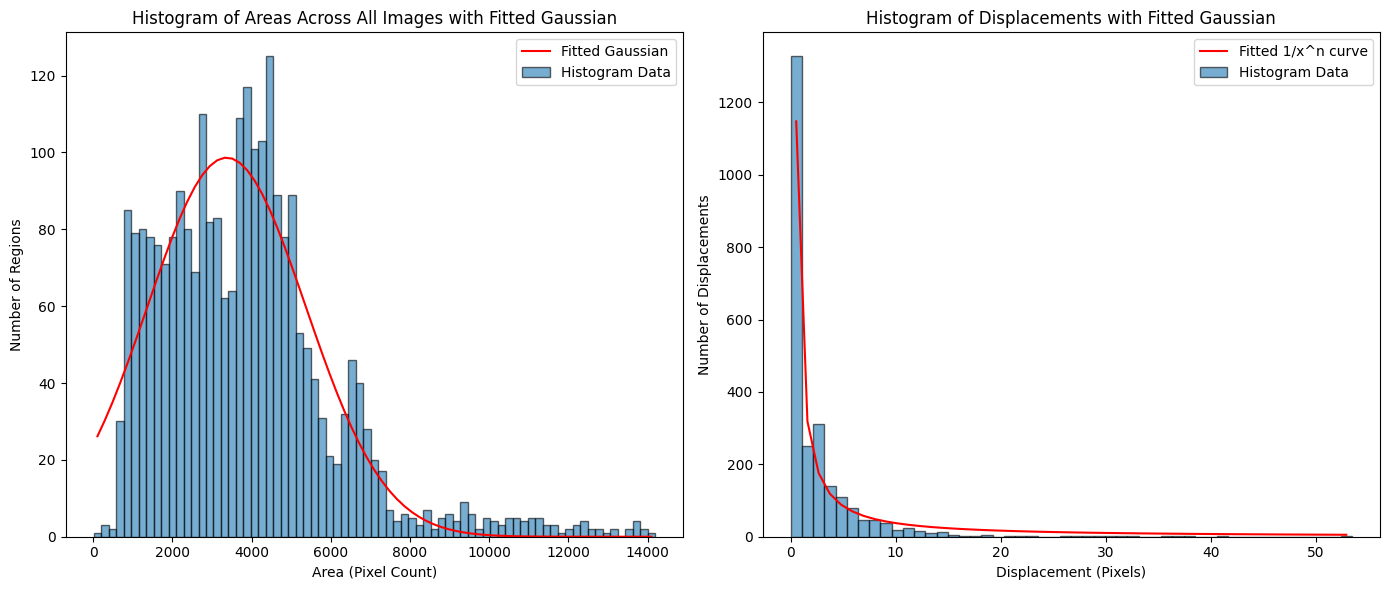

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720


In [3]:
path='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7'
name='Fluo'
save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo_train'
generate_CTC_datasets(path,name,save_dir)